In [1]:
import pandas as pd
import re
from transformers import pipeline
from sklearn.cluster import KMeans
import numpy as np

# 텍스트 전처리 함수
def preprocess_text(text):
    if isinstance(text, str):
        # 소문자화 (영문만 처리)
        text = text.lower()
        # 특수문자 및 숫자 제거
        text = re.sub(r'[^a-zA-Z가-힣\s]', '', text)
        # 공백 제거
        text = ' '.join(text.split())
        # 텍스트 길이 512자 이하로 자르기
        max_length = 512
        if len(text) > max_length:
            text = text[:max_length]
        return text
    return ''  # 텍스트가 아닌 경우 빈 문자열 반환

# 감정 분석을 위한 함수
def analyze_sentiment(row):
    reviews = [row['review1'], row['review2'], row['review3']]
    processed_reviews = [preprocess_text(review) for review in reviews if review != 'Blank' and pd.notna(review)]

    # 감정 분석 수행
    sentiment_scores = []
    for review in processed_reviews:
        # 긴 리뷰를 여러 부분으로 나누기
        max_chunk_length = 200  # 한 번에 분석할 최대 텍스트 길이
        chunks = [review[i:i+max_chunk_length] for i in range(0, len(review), max_chunk_length)]
        
        for chunk in chunks:
            sentiment = sentiment_analyzer(chunk)
            sentiment_scores.append(sentiment[0]['label'])  # 'LABEL_0' 또는 'LABEL_1'

    # 감정 점수를 평균으로 계산
    sentiment_score = sentiment_scores.count('POSITIVE') / len(sentiment_scores) if sentiment_scores else 0
    return sentiment_score

# 파일 경로 설정
file_path = r"C:\Users\sam99\Desktop\코멘토_데이터분석\Rental_Car_review.csv"  # 로컬 파일 경로
df = pd.read_csv(file_path, encoding='ISO-8859-1')  # ISO-8859-1 인코딩 사용

# 'Blank' 값을 NaN으로 변환
df.replace('Blank', np.nan, inplace=True)

# 감정 분석 파이프라인 준비
sentiment_analyzer = pipeline('sentiment-analysis')

# 감정 분석을 통해 새로운 열 추가
df['Sentiment_Score'] = df.apply(analyze_sentiment, axis=1)

# Sentiment_Score가 NaN인 행 제거 (Blank나 NaN인 리뷰는 분석에서 제외)
df_cleaned = df.dropna(subset=['Sentiment_Score'])  # Sentiment_Score가 결측치인 행 제거

# K-means 클러스터링
X = df_cleaned[['Consumer reviews', 'Sentiment_Score']].values  # 리뷰와 감정 점수 데이터를 사용
kmeans = KMeans(n_clusters=2, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(X)

# 클러스터링 결과를 원본 데이터에 반영
df['Cluster'] = df.apply(
    lambda row: df_cleaned[df_cleaned['ID'] == row['ID']]['Cluster'].values[0] if not df_cleaned[df_cleaned['ID'] == row['ID']].empty and pd.notna(row['Sentiment_Score']) else np.nan,
    axis=1
)

# 결과 확인
print("감정 분석 결과:")
print(df[['Consumer reviews', 'Sentiment_Score']].head())

print("\nK-means 클러스터링 결과:")
print(df[['Consumer reviews', 'Sentiment_Score', 'Cluster']].head())

# 클러스터별 리뷰 출력
for cluster in range(2):
    print(f"\nCluster {cluster} Reviews:")
    cluster_reviews = df[df['Cluster'] == cluster]['Consumer reviews'].values
    print(list(cluster_reviews))

# 결과를 엑셀 파일로 저장
df.to_excel(r"C:\Users\sam99\Desktop\코멘토_데이터분석\clustered_reviews.xlsx", index=False)





No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


감정 분석 결과:
   Consumer reviews  Sentiment_Score
0               0.0         0.000000
1               4.6         0.555556
2               4.6         0.714286
3               5.0         1.000000
4               5.0         0.800000

K-means 클러스터링 결과:
   Consumer reviews  Sentiment_Score  Cluster
0               0.0         0.000000        0
1               4.6         0.555556        1
2               4.6         0.714286        1
3               5.0         1.000000        1
4               5.0         0.800000        1

Cluster 0 Reviews:
[0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Cluster 1 Reviews:
[4.6, 4.6, 5.0, 5.0, 5.0, 5.0, 3.3, 5.0, 3.7, 5.0, 4.8, 5.0, 5.0, 3.8, 4.2, 4.8, 5.0, 4.0, 4.8, 5.0, 4.9, 4

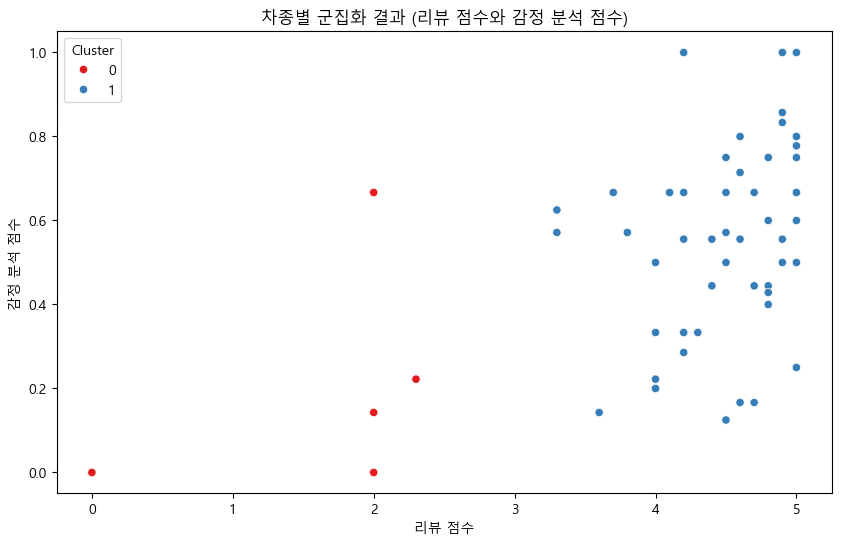

In [4]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='Malgun Gothic')  # Windows에서 사용하는 한글 폰트 (Mac에서는 'AppleGothic', Linux에서는 'NanumGothic' 등 사용)


# 군집화 모델 (예: KMeans)
kmeans = KMeans(n_clusters=2, random_state=42)  # 2개의 군집으로 설정
df['Cluster'] = kmeans.fit_predict(df[['Consumer reviews', 'Sentiment_Score']])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Consumer reviews', y='Sentiment_Score', hue='Cluster', palette='Set1')
plt.title('차종별 군집화 결과 (리뷰 점수와 감정 분석 점수)')
plt.xlabel('리뷰 점수')
plt.ylabel('감정 분석 점수')
plt.legend(title='Cluster')
plt.show()

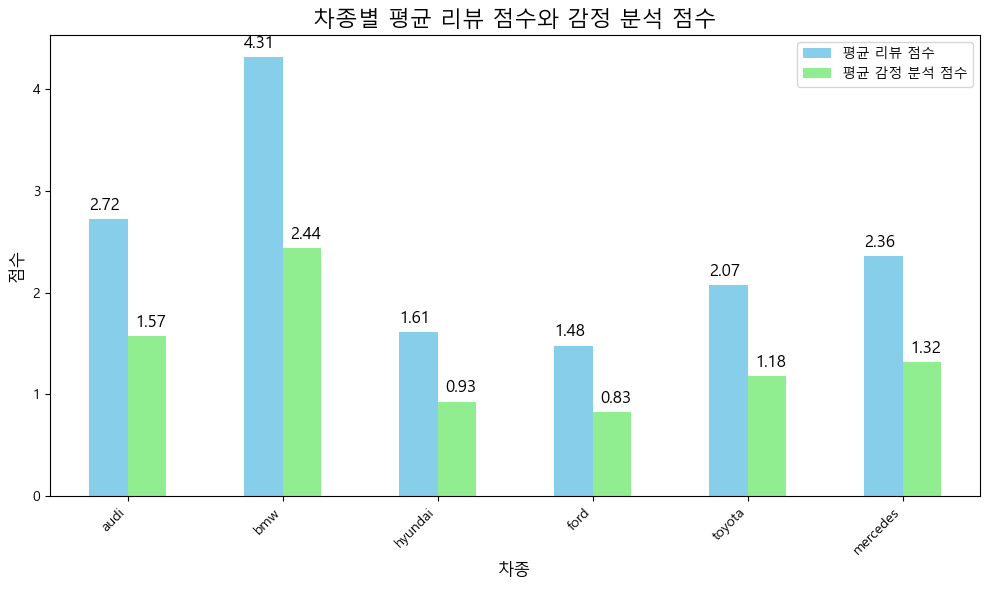

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

# 한글 폰트 설정
rc('font', family='Malgun Gothic')  # Windows에서 사용하는 한글 폰트 (Mac에서는 'AppleGothic', Linux에서는 'NanumGothic' 등 사용)

# 예시 데이터프레임 (df) 생성
# 실제 데이터로 교체하세요.
data = {
    'car_name': ['audi A4', 'bmw 320i', 'hyundai Sonata', 'ford Focus', 'toyota Camry', 'mercedes Benz'],
    'Consumer reviews': [2.72, 4.31, 1.61, 1.48, 2.07, 2.36],
    'Sentiment_Score': [1.57, 2.44, 0.93, 0.83, 1.18, 1.32]
}
df = pd.DataFrame(data)

# 'car_name'에서 차종만 추출하여 새로운 'car_brand' 칼럼 생성
df['car_brand'] = df['car_name'].apply(lambda x: x.split()[0].lower())

# 차종별 Consumer Reviews 평균과 Sentiment_Score 평균 계산
car_preference = df.groupby('car_brand').agg(
    average_reviews=('Consumer reviews', 'mean'),  # 'Consumer reviews'의 평균
    average_sentiment_score=('Sentiment_Score', 'mean')  # 'Sentiment_Score'의 평균
)

# 특정 차종 선택 (Audi, BMW, Hyundai, Ford, Toyota, Mercedes)
selected_cars = ['audi', 'bmw', 'hyundai', 'ford', 'toyota', 'mercedes']
car_preference_selected = car_preference.loc[selected_cars]

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))  # 그래프 크기 조정

# 두 가지 값을 각각 다른 색으로 시각화 (막대그래프)
car_preference_selected.plot(kind='bar', ax=ax, color=['skyblue', 'lightgreen'])

# 제목 및 레이블 설정
plt.title('차종별 평균 리뷰 점수와 감정 분석 점수', fontsize=16)
plt.xlabel('차종', fontsize=12)
plt.ylabel('점수', fontsize=12)

# x축 레이블 회전 및 간격 조정
plt.xticks(rotation=45, ha='right')

# 범례 추가
plt.legend(['평균 리뷰 점수', '평균 감정 분석 점수'])

# 각 바 위에 숫자 추가
for i, (review, sentiment) in enumerate(zip(car_preference_selected['average_reviews'], car_preference_selected['average_sentiment_score'])):
    ax.text(i - 0.15, review + 0.05, f'{review:.2f}', ha='center', va='bottom', fontsize=12)  # 리뷰 점수 숫자
    ax.text(i + 0.15, sentiment + 0.05, f'{sentiment:.2f}', ha='center', va='bottom', fontsize=12)  # 감정 점수 숫자

# 그래프 표시
plt.tight_layout()  # 레이블이 겹치지 않도록 레이아웃 조정
plt.show()




In [6]:
print(df.columns)

Index(['car_name', 'Consumer reviews', 'Sentiment_Score', 'car_brand'], dtype='object')


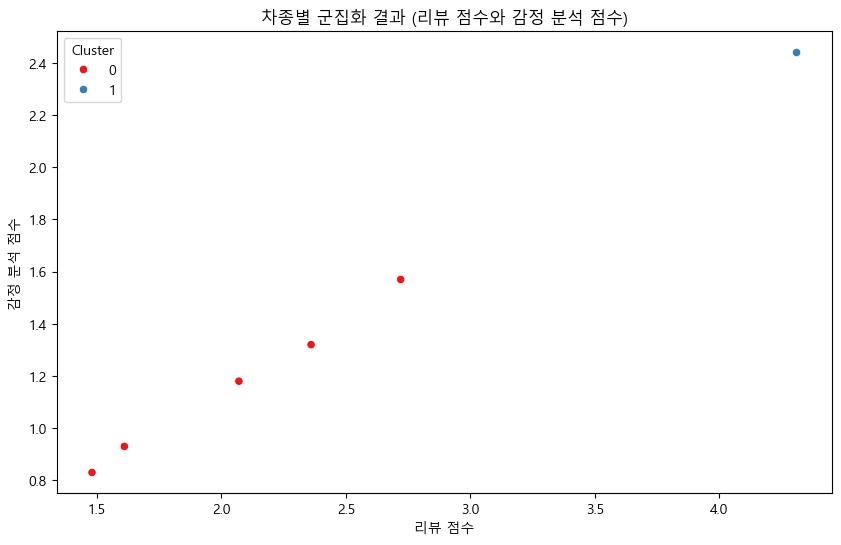

In [7]:
from sklearn.cluster import KMeans

# 군집화 모델 (예: KMeans)
kmeans = KMeans(n_clusters=2, random_state=42)  # 2개의 군집으로 설정
df['Cluster'] = kmeans.fit_predict(df[['Consumer reviews', 'Sentiment_Score']])
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Consumer reviews', y='Sentiment_Score', hue='Cluster', palette='Set1')
plt.title('차종별 군집화 결과 (리뷰 점수와 감정 분석 점수)')
plt.xlabel('리뷰 점수')
plt.ylabel('감정 분석 점수')
plt.legend(title='Cluster')
plt.show()


In [8]:
# 군집별 평균 리뷰 점수와 감정 분석 점수
cluster_summary = df.groupby('Cluster').agg(
    average_review=('Consumer reviews', 'mean'),
    average_sentiment_score=('Sentiment_Score', 'mean')
)

print(cluster_summary)


         average_review  average_sentiment_score
Cluster                                         
0                 2.048                    1.166
1                 4.310                    2.440


c:\Users\sam99\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sam99\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\sam99\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


   Year  Forecasted_Demand
5  2021       1.078292e+06
6  2022       1.139254e+06
7  2023       1.193674e+06
8  2024       1.242253e+06
9  2025       1.285618e+06


c:\Users\sam99\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\sam99\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


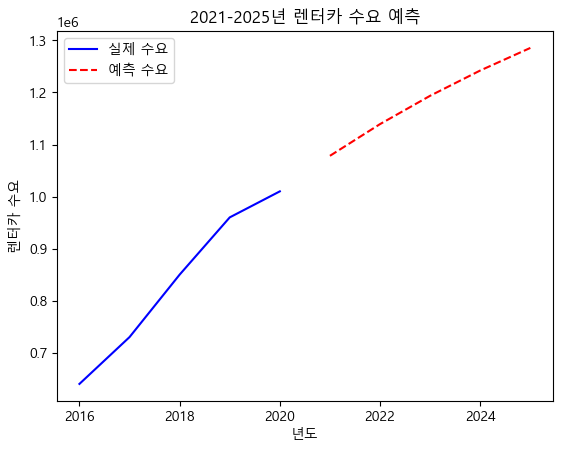

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# 시계열 데이터 준비 (2016년~2020년 수요 데이터)
years = [2016, 2017, 2018, 2019, 2020]
demand = [640000, 730000, 850000, 960000, 1010000]
#출처: https://blog.naver.com/newheater/222086127026
# 데이터프레임 생성
df_demand = pd.DataFrame({'Year': years, 'Demand': demand})
df_demand.set_index('Year', inplace=True)

# 시계열 모델 훈련 (ARIMA 모델)
model = ARIMA(df_demand['Demand'], order=(1, 1, 1))  # ARIMA(p,d,q)에서 p, d, q는 적합도에 맞게 설정
model_fit = model.fit()

# 예측: 2025년까지 예측
forecast = model_fit.forecast(steps=5)  # 2021~2025년 예측

# 예측값 출력
forecast_years = [2021, 2022, 2023, 2024, 2025]
forecast_df = pd.DataFrame({'Year': forecast_years, 'Forecasted_Demand': forecast})

# 결과 출력
print(forecast_df)

# 예측 결과 시각화
plt.plot(df_demand.index, df_demand['Demand'], label='실제 수요', color='blue')
plt.plot(forecast_df['Year'], forecast_df['Forecasted_Demand'], label='예측 수요', color='red', linestyle='dashed')
plt.xlabel('년도')
plt.ylabel('렌터카 수요')
plt.title('2021-2025년 렌터카 수요 예측')
plt.legend()
plt.show()



In [16]:
#아쉬운 점과 이번 데이터 분석 프로젝트에 대한 연구 한계

#1. 텍스트 마이닝 기법에서 신뢰할 수 있는 리뷰인가를 검토하는 작업이 다소 불확실한 것(캐글에 있는 렌터카 리뷰 데이터만을 가지고 진행하였기 때문이다.)
#예를 들어서 기업에서 활용하는 제품 판매 댓글 알바 라던지 이러한 신뢰할 수 없는 리뷰를 통해 고객에게 충동 구매를 유발한다던지.. 확실한 검토 작업 요구되되는 분석
#2. 수요 예측 모델링 선정에 어려움을 느꼈다. 주제가 다소 불확실하였기 때문? 
# 사실 만들어내고 싶었지만.. 내가 원했던 프로젝트 전체적인 빅픽처는 '감정분석과 리뷰 별점에 따른 렌터카 차종별 수요량 예측'이었는데  해당하는 렌터카의 차종별 수요량
# 데이터가 확실하게 나와있는 데이터를 찾아보기 힘들었다.
# 그래서 주제를 약간 변형하여 해당하는 차종별 수요량 예측에서 감정분석과 리뷰 별점에 따른 향후 2025년~2026년 고객 렌터카 수요량 예측으로라도 바꿔보려 했으나 
# 이러한 경우엔 또 과거 데이터 2016년, 2017년, 2018년 2019년, 2020년 등 이전 최소 5개년치에 감정분석 데이터와 리뷰 별점에 관한 내용을 모두 종합적으로 
# 다시 계산하고 데이터 작업을 거쳐야 하는 것을 깨달았다.. 관련 데이터를 찾을 수만 있으면 고도화하여 예측 모델링 개발에 힘써보고 싶다는 생각이 들었다. 
# 데이터 수집 과정이 만만치 않은 과정으로 수요량 예측 모델링을 제대로 구현하지 못한 점이 다소 아쉽게 남은 프로젝트.


In [17]:
import pandas as pd

# 데이터 불러오기
file_path = r"C:\Users\sam99\Desktop\코멘토_데이터분석\clustered_reviews.xlsx"
data = pd.read_excel(file_path)

# 데이터 확인
print(data.head())


   ID car_name  Consumer reviews  \
0   1  audi A1               0.0   
1   2  audi A6               4.6   
2   3  audi A4               4.6   
3   4  audi A3               5.0   
4   5  audi Q3               5.0   

                                             review1  \
0                                                NaN   
1  I had looked at the Mercedes E Class, BMW 5 Se...   
2  Best car I've ever owned, hands down. I am a 3...   
3  I am so impressed with the new A3, itfs quick...   
4  While I am reviewing the Q3 I got a mere five ...   

                                             review2  \
0                                                NaN   
1  This car seems to eat oil. I bought this vehic...   
2  Traded in my 2005.5 A-4, which I dearly loved ...   
3  I must I love my car, we originally went in lo...   
4  I transport my most price possessions in this ...   

                                             review3  Sentiment_Score  Cluster  
0                           

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# 데이터 불러오기
file_path = r"C:\Users\sam99\Desktop\코멘토_데이터분석\clustered_reviews.xlsx"
data = pd.read_excel(file_path)

# 결측값 처리 (리뷰 텍스트 결합)
data['review_text'] = data[['review1', 'review2', 'review3']].fillna('').apply(lambda x: ' '.join(x), axis=1)

# review_text가 빈 문자열("")인 경우 Sentiment_Score와 Cluster도 NaN으로 처리
data.loc[data['review_text'].str.strip() == '', ['Sentiment_Score', 'Cluster']] = np.nan

# 결측값이 있는 행 제거 (필요한 경우)
data = data.dropna(subset=['review_text', 'Sentiment_Score', 'Cluster'])

# 텍스트 데이터 확인
print(data[['review_text', 'Sentiment_Score', 'Cluster']].head())

# 훈련 데이터와 테스트 데이터 분리
X = data['review_text']
y = data['Sentiment_Score']  # 감정 점수를 예측 타겟으로 설정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 크기 확인
print(f"훈련 데이터 크기: {len(X_train)}, 테스트 데이터 크기: {len(X_test)}")

# 전처리된 데이터를 새로운 엑셀 파일로 저장
output_file_path = r"C:\Users\sam99\Desktop\코멘토_데이터분석\preprocessed_reviews.xlsx"
data.to_excel(output_file_path, index=False)
print(f"전처리된 데이터가 {output_file_path}에 저장되었습니다.")




                                         review_text  Sentiment_Score  Cluster
1  I had looked at the Mercedes E Class, BMW 5 Se...         0.555556      1.0
2  Best car I've ever owned, hands down. I am a 3...         0.714286      1.0
3  I am so impressed with the new A3, itfs quick...         1.000000      1.0
4  While I am reviewing the Q3 I got a mere five ...         0.800000      1.0
5  Great suv with many bells and whistles. Smooth...         0.800000      1.0
훈련 데이터 크기: 58, 테스트 데이터 크기: 15
전처리된 데이터가 C:\Users\sam99\Desktop\코멘토_데이터분석\preprocessed_reviews.xlsx에 저장되었습니다.


In [19]:
# 저장된 엑셀 파일 불러오기
data = pd.read_excel(output_file_path)

# 필요한 전처리 과정 이어가기
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 훈련 데이터와 테스트 데이터 분리
X = data['review_text']
y = data['Sentiment_Score']  # 감정 점수를 예측 타겟으로 설정
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 텍스트 데이터 전처리: Tokenizer로 텍스트를 숫자 벡터로 변환
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# 패딩 추가
maxlen = 100  # 입력 텍스트 길이를 100으로 제한
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

# 데이터 크기 확인
print(f"훈련 데이터 크기: {len(X_train_pad)}, 테스트 데이터 크기: {len(X_test_pad)}")


훈련 데이터 크기: 58, 테스트 데이터 크기: 15


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# 모델 정의
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='linear'))  # Sentiment_Score는 연속형 값이므로 linear 활성화 함수 사용

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# 모델 학습
model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

# 모델 평가
loss, mae = model.evaluate(X_test_pad, y_test)
print(f"테스트 데이터에서의 MAE: {mae}")


c:\Users\sam99\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - loss: 0.4517 - mae: 0.6099 - val_loss: 0.4109 - val_mae: 0.5911
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.3635 - mae: 0.5352 - val_loss: 0.3141 - val_mae: 0.5045
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2459 - mae: 0.4255 - val_loss: 0.1562 - val_mae: 0.3515
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0953 - mae: 0.2504 - val_loss: 0.1486 - val_mae: 0.3154
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.2608 - mae: 0.4163 - val_loss: 0.0626 - val_mae: 0.2107
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0597 - mae: 0.2011 - val_loss: 0.1088 - val_mae: 0.2981
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0704 - mae: 0.2238 - val_loss: 0.1315 - val_mae: 0.3254
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0788 - mae: 0.2328 - val_loss: 0.1327 - val_mae: 0.3264
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0520 - mae: 

In [21]:
import pandas as pd
import numpy as np

# 데이터 로드
file_path = r"C:\Users\sam99\Desktop\코멘토_데이터분석\clustered_reviews.xlsx"
data = pd.read_excel(file_path)

# 결측값 처리 및 리뷰 텍스트 결합
data['review_text'] = data[['review1', 'review2', 'review3']].fillna('').apply(lambda x: ' '.join(x), axis=1)

# 리뷰 텍스트와 감정 점수 확인
print(data[['review_text', 'Sentiment_Score']].head())


                                         review_text  Sentiment_Score
0                                                            0.000000
1  I had looked at the Mercedes E Class, BMW 5 Se...         0.555556
2  Best car I've ever owned, hands down. I am a 3...         0.714286
3  I am so impressed with the new A3, itfs quick...         1.000000
4  While I am reviewing the Q3 I got a mere five ...         0.800000


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder

# 사용자와 상품 ID를 숫자로 인코딩
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

data['user_id'] = user_encoder.fit_transform(data['ID'])
data['item_id'] = item_encoder.fit_transform(data['car_name'])

# X 데이터 준비 (사용자와 상품 ID)
X_user = data['user_id'].values
X_item = data['item_id'].values
y = data['Sentiment_Score'].values

# 모델 구축
user_input = layers.Input(shape=(1,), name='user')
item_input = layers.Input(shape=(1,), name='item')

# 사용자와 아이템 임베딩 레이어
user_embedding = layers.Embedding(input_dim=len(user_encoder.classes_), output_dim=50)(user_input)
item_embedding = layers.Embedding(input_dim=len(item_encoder.classes_), output_dim=50)(item_input)

# 임베딩을 평탄화
user_vec = layers.Flatten()(user_embedding)
item_vec = layers.Flatten()(item_embedding)

# 두 벡터를 결합
concat = layers.Concatenate()([user_vec, item_vec])

# Fully Connected Layer
fc1 = layers.Dense(128, activation='relu')(concat)
fc2 = layers.Dense(64, activation='relu')(fc1)
output = layers.Dense(1)(fc2)

# 모델 정의
model = models.Model(inputs=[user_input, item_input], outputs=output)

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit([X_user, X_item], y, epochs=10, batch_size=32, validation_split=0.2)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 예측값 계산
y_pred = model.predict([X_user, X_item])

# MSE, RMSE, MAE 계산
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.2379 - val_loss: 0.1453
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1890 - val_loss: 0.1266
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1554 - val_loss: 0.1199
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1245 - val_loss: 0.1257
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0894 - val_loss: 0.1389
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0747 - val_loss: 0.1532
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0557 - val_loss: 0.1566
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0395 - val_loss: 0.1539
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0234 - val_loss: 0.1475
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0119 - val_loss: 0.1437
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
MSE: 0.03319969270767297
RMSE: 0.18220782833806282
MAE: 0.11732006610407138


In [24]:
# 특정 사용자에게 추천할 차종을 예측
user_id = 0  # 예시로 첫 번째 사용자
top_n_recommendations = []

for item_id in range(len(item_encoder.classes_)):
    score = model.predict([np.array([user_id]), np.array([item_id])])
    top_n_recommendations.append((item_encoder.classes_[item_id], score[0][0]))

# 점수 순으로 상위 5개 상품 추천
top_n_recommendations.sort(key=lambda x: x[1], reverse=True)
top_5_recommendations = top_n_recommendations[:5]

print("추천된 상품 (차종) 상위 5개:")
for car, score in top_5_recommendations:
    print(f"차종: {car}, 예측 점수: {score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━